In [93]:
import numpy as np      
import matplotlib.pyplot as plt 
import scipy.io.wavfile 
import subprocess
import librosa
import librosa.display
import IPython.display as ipd
import random
import csv
import pickle
import os
import matplotlib.pyplot as plt

from collections import defaultdict
from collections import OrderedDict
from pathlib import Path, PurePath   
from tqdm.notebook import tqdm
from collections import Counter
from operator import itemgetter

## Utility functions

In [14]:
def convert_mp3_to_wav(audio:str) -> str:  
    """Convert an input MP3 audio track into a WAV file.

    Args:
        audio (str): An input audio track.

    Returns:
        [str]: WAV filename.
    """
    if audio[-3:] == "mp3":
        wav_audio = audio[:-3] + "wav"
        if not Path(wav_audio).exists():
                subprocess.check_output(f"ffmpeg -i {audio} {wav_audio}", shell=True)
        return wav_audio
    
    return audio

def plot_spectrogram_and_picks(track:np.ndarray, sr:int, peaks:np.ndarray, onset_env:np.ndarray) -> None:
    """[summary]

    Args:
        track (np.ndarray): A track.
        sr (int): Aampling rate.
        peaks (np.ndarray): Indices of peaks in the track.
        onset_env (np.ndarray): Vector containing the onset strength envelope.
    """
    times = librosa.frames_to_time(np.arange(len(onset_env)),
                            sr=sr, hop_length=HOP_SIZE)

    plt.figure()
    ax = plt.subplot(2, 1, 2)
    D = librosa.stft(track)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(D), ref=np.max),
                            y_axis='log', x_axis='time')
    plt.subplot(2, 1, 1, sharex=ax)
    plt.plot(times, onset_env, alpha=0.8, label='Onset strength')
    plt.vlines(times[peaks], 0,
            onset_env.max(), color='r', alpha=0.8,
            label='Selected peaks')
    plt.legend(frameon=True, framealpha=0.8)
    plt.axis('tight')
    plt.tight_layout()
    plt.show()

def load_audio_picks(audio, duration, hop_size):
    """[summary]

    Args:
        audio (string, int, pathlib.Path or file-like object): [description]
        duration (int): [description]
        hop_size (int): 

    Returns:
        tuple: Returns the audio time series (track) and sampling rate (sr), a vector containing the onset strength envelope
        (onset_env), and the indices of peaks in track (peaks).
    """
    try:
        track, sr = librosa.load(audio, duration=duration)
        onset_env = librosa.onset.onset_strength(track, sr=sr, hop_length=hop_size)
        peaks = librosa.util.peak_pick(onset_env, 10, 10, 10, 10, 0.5, 0.5)
    except Error as e:
        print('An error occurred processing ', str(audio))
        print(e)

    return track, sr, onset_env, peaks

## Settings

In [15]:
N_TRACKS = 1413
HOP_SIZE = 512
DURATION = 30 # TODO: to be tuned!
THRESHOLD = 0 # TODO: to be tuned!

In [19]:
data_folder = Path("data/mp3s-32k/")
mp3_tracks = data_folder.glob("*/*/*.mp3")
tracks = data_folder.glob("*/*/*.wav")

## Preprocessing

In [5]:
for track in tqdm(mp3_tracks, total=N_TRACKS):
    convert_mp3_to_wav(str(track))

  0%|          | 0/1413 [00:00<?, ?it/s]

## Audio Signals

In [6]:
#for idx, audio in enumerate(tracks):
#    if idx >= 4:
#        break
#    track, sr, onset_env, peaks = load_audio_picks(audio, DURATION, HOP_SIZE)
#    plot_spectrogram_and_picks(track, sr, peaks, onset_env)
#    seed = [1,132,48,962,95,88]
#    print(minhash(peaks,DURATION,seed[0]))

In [20]:
# creating dictionary name song <---> number song
num_song = OrderedDict()

for idx, audio in tqdm(enumerate(tracks),total = N_TRACKS):
    audio = os.path.normpath(audio)
    info = audio.split(os.sep)[2:]
    info = [x.replace("_", " ") for x in info]
    info[2] = info[2][3:].replace(".wav", "")
    info[0] = info[0].title()
        
    num_song[idx] = info
    
with open('data/num_to_song.pkl','wb') as f:
    pickle.dump(num_song,f)

  0%|          | 0/1413 [00:00<?, ?it/s]

In [21]:
# creating dictionary id song <---> peaks array
def findPeaks(duration):
    dict_ = OrderedDict()
    data_folder = Path("data/mp3s-32k/")
    tracks = data_folder.glob("*/*/*.wav")
    
    for idx, audio in tqdm(enumerate(tracks),total = N_TRACKS):
    
        track, sr, onset_env, peaks = load_audio_picks(audio, duration, HOP_SIZE)
        dict_[idx] = peaks
        
    with open('data/peaks/{}_sec.pkl'.format(duration),'wb') as f:
        pickle.dump(dict_,f)

## Minhash

The minhash function follows not the procedure explained in section 3 of the mmds book but rather revolves around the use of random linear coefficents. We develop a family of hash function by randomly selecting a number of coefficents equal to the number of peaks of the song, do an inner product between the vectors and a modulo operation to bucket the result. This repeated a set amount of times (so a set amount of different hash functions) using the same seeds allows consistency. 

In [81]:
def minhash(peaks,duration,seed):
    random.seed(seed)
    coeff = random.sample([i for i in range(3000)],len(peaks))
    val = sum(np.multiply(coeff,peaks))
    bin_ = val%800
    return bin_

In [82]:
def findBin(duration):
    seeds = [21,123,45,87,656]
    # for every hash function
    for i in range(len(seeds)):
        bins = defaultdict(list)

        with open('data/peaks/{}_sec.pkl'.format(duration),'rb') as f:
            file = pickle.load(f)
        # for every song
        for k, v in file.items():
            bins[minhash(v,duration,seeds[i])].append(k)
        # save bin number inside a file for each hash function    
        with open('data/bin/duration {} sec/bins_h({}).pkl'.format(duration,i+1),'wb') as f:
            pickle.dump(bins,f)
        f.close()

In [83]:
def loadBin(duration):
    with open('data/bin/duration {} sec/bins_h(1).pkl'.format(duration),'rb') as f:
        bins_1 = pickle.load(f)
    with open('data/bin/duration {} sec/bins_h(2).pkl'.format(duration),'rb') as f:
        bins_2 = pickle.load(f)
    with open('data/bin/duration {} sec/bins_h(3).pkl'.format(duration),'rb') as f:
        bins_3 = pickle.load(f)
    with open('data/bin/duration {} sec/bins_h(4).pkl'.format(duration),'rb') as f:
        bins_4 = pickle.load(f)
    with open('data/bin/duration {} sec/bins_h(5).pkl'.format(duration),'rb') as f:
        bins_5 = pickle.load(f)
    
    return bins_1, bins_2, bins_3, bins_4, bins_5

In [97]:
# now that we have the bins, we analyze queries
def queryGuess(query,duration,threshold):
    q_bin = []
    seeds = [21,123,45,87,656]
    bins_1, bins_2, bins_3, bins_4, bins_5 = loadBin(duration)
    with open('data/num_to_song.pkl','rb') as f:
        num_song = pickle.load(f)
    # minhash queries    
    for i in range(len(seeds)):
        track, sr, onset_env, peaks = load_audio_picks(query, duration, HOP_SIZE)
        value = minhash(peaks,duration,seeds[i])
        q_bin.append(value)
    
    # songs are chosen in the buckets gathered by the hashing of the query
    possible_songs = bins_1[q_bin[0]] + bins_2[q_bin[1]] + bins_3[q_bin[2]] + bins_4[q_bin[3]] + bins_5[q_bin[4]]
    possible_songs = Counter(possible_songs)
    # here the threshold is implemented for 5 hash functions
    guessed_idx = [k for k,v in possible_songs.items() if v>=threshold*5]
    guessed_song = itemgetter(*guessed_idx)(num_song)
    
    return guessed_song

In [123]:
def findSong(duration,show,threshold):
    if show == True:
        print ("\033[1m{:<23} {:<25} {:<10}\033[0m \n".format('Title','Album','Band'))
    folder = Path("data/queries/")
    queries = folder.glob("*.wav")
    if not os.path.exists('data/bin/duration {} sec/'.format(duration)):
        os.mkdir('data/bin/duration {} sec/'.format(duration))
        findPeaks(duration)
    findBin(duration)
    result = []
    for idx, audio in enumerate(queries):
        print("query #{}--------------------------------------------".format(idx+1))
        song = queryGuess(audio,duration,threshold)
        if type(song) == tuple:
            result.append(song[2])   
            for song_ in song:
                if show == True:
                    print("{:<23} {:<25} {:<10}".format(song_[2],song_[1],song_[0]) )
        elif type(song) == list:
            if show == True:
                    print("{:<23} {:<25} {:<10}".format(song[2],song[1],song[0]) )
            
    return result

## Query results

since the algorithm is so powerful we can show results that appear with a threshold below 1/5 and above it. since only the correct answer turns out in all 5 bins, while the others appear in mostly 1 bin

In [125]:
ans = findSong(5, True,0.50)

Title                   Album                     Band       

query #1--------------------------------------------
Dream On                Aerosmith                 Aerosmith 
query #2--------------------------------------------
Black Friday            Katy Lied                 Steely Dan
query #3--------------------------------------------
I Want To Break Free    The Works                 Queen     
query #4--------------------------------------------
October                 October                   U2        
query #5--------------------------------------------
Ob-La-Di Ob-La-Da       The White Album Disc 1    Beatles   
query #6--------------------------------------------
Karma Police            OK Computer               Radiohead 
query #7--------------------------------------------
Heartbreaker            Led Zeppelin II           Led Zeppelin
query #8--------------------------------------------
Go Your Own Way         Rumours                   Fleetwood Mac
query #9------------

In [124]:
ans = findSong(5, True,0.19)

Title                   Album                     Band       

query #1--------------------------------------------
Dream On                Aerosmith                 Aerosmith 
Express Yourself        Like A Prayer             Madonna   
Dirty Day               Zooropa                   U2        
St Jimmy                American Idiot            Green Day 
Sail Away Sweet Sister  The Game                  Queen     
I Might Be Wrong        Amnesiac                  Radiohead 
Gloria                  October                   U2        
Jump In The Fire        Kill Em All               Metallica 
Joy Of A Toy            Pearls of Passion 1997 Remaster  Roxette   
Somebody                Some Great Reward         Depeche Mode
Can t Go Back           Mirage                    Fleetwood Mac
In This Life            Erotica                   Madonna   
My Friend of Misery     Metallica                 Metallica 
query #2--------------------------------------------
I ll Be Back            A 

In [ ]:
solution = set(['Dream On', 'Black Friday', 'I Want To Break Free', 'October', 'Ob-La-Di Ob-La-Da', 'Karma Police', 'Heartbreaker',
     'Go Your Own Way','American Idiot', 'Somebody'])
t = []
accuracy = []
for i in range(1,21,1):
    duration = i/10
    t.append(duration)
    guess = findSong(duration,False,0.5)
    correct = solution.intersection(guess)
    accuracy.append(len(correct)*10)

admittedly a bit surprising but the aforementioned procedure gives astounding results as shown in the plot below. Accuracy is at 90% when we let songs play for as little as 1,5 seconds

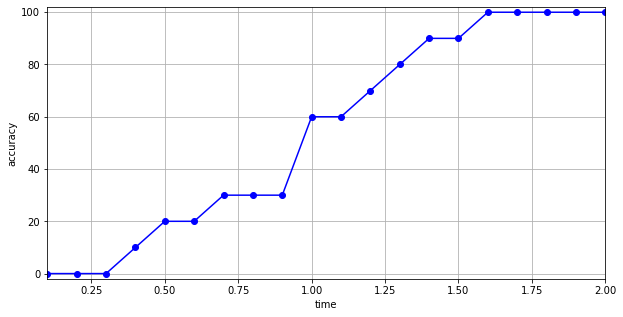

In [95]:
plt.figure(figsize=(10, 5))
plt.plot(t,accuracy,'b-o')
plt.grid()
plt.xlim(0.1, 2)
plt.ylim(-2, 102)
plt.xlabel('time')
plt.ylabel('accuracy')
plt.show()